# Решение задачи сегментации для датасета A2D2

In [58]:
from global_names import A2D2_PATH
import os, json
    
with open(os.path.join(A2D2_PATH, "camera_lidar_semantic", "class_list.json"), "rb") as f:
     class_list= json.load(f)

Датасет содержит съёмки с камер, некоторые из которых размечены на 55 классов.
<br>
Список классов можно увидеть ниже:

In [17]:
print(*class_list.values(), sep="; ")

Car 1; Car 2; Car 3; Car 4; Bicycle 1; Bicycle 2; Bicycle 3; Bicycle 4; Pedestrian 1; Pedestrian 2; Pedestrian 3; Truck 1; Truck 2; Truck 3; Small vehicles 1; Small vehicles 2; Small vehicles 3; Traffic signal 1; Traffic signal 2; Traffic signal 3; Traffic sign 1; Traffic sign 2; Traffic sign 3; Utility vehicle 1; Utility vehicle 2; Sidebars; Speed bumper; Curbstone; Solid line; Irrelevant signs; Road blocks; Tractor; Non-drivable street; Zebra crossing; Obstacles / trash; Poles; RD restricted area; Animals; Grid structure; Signal corpus; Drivable cobblestone; Electronic traffic; Slow drive area; Nature object; Parking area; Sidewalk; Ego car; Painted driv. instr.; Traffic guide obj.; Dashed line; RD normal street; Sky; Buildings; Blurred area; Rain dirt


Нужно отметить, что классы car 1, car 2... используются для тех случев, когда машины имеют общую границу. Поэтому называть это "семантической" сегментацией несовсем верно. 
<br>
Также важно понимать, что в случае необходимости создания модели для семантической сегментации, можно использовать тот же подход, просто упразднив классы car 1, car 2 ... и заменив их одним классом car.
<br>
Модель, которая будет получена в результате такого упразднения классов, будет иметь точность выше, чем та, которая представлена в отчёте.

## Подход для работы с данными

Исходный датасет был разделён на тренировочную, валидационную и тестовую выборки.
<br>
Все изображения были отсортированы по дате съёмки. Таким образом в выборках все кадры идут по порядку.
<br>
Для удобства хранения и обработки был создан словарь `bm_ds`, содержащий списки с уникальными `id` для каждой съёмки, для которой присутствовали размеченные данные. Получить из `id` пути до данных можно с помощью функций из модуля `global_names.py`
<br>
Для корректной работы достаточно указать корректный абсолютный путь до распакованного датасета для имени `A2D2_PATH`

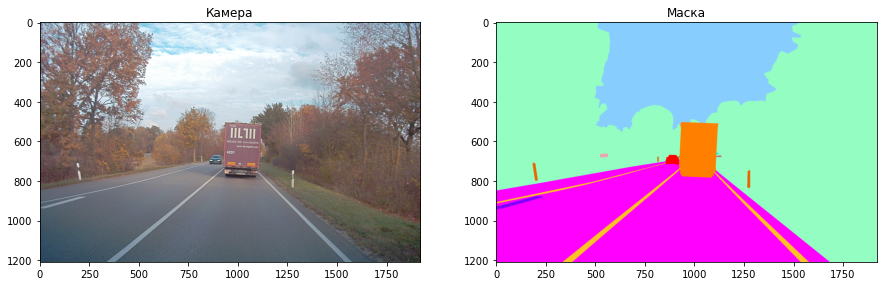

In [60]:
from global_names import sensor_p, abs_
import pickle, random
import matplotlib.pyplot as plt
%matplotlib inline

with open("bm_ds.pkl", "rb") as f:
    bm_ds = pickle.load(f)

rand_id =  random.choice(bm_ds['test_ids'])

lidar_path = abs_(sensor_p(id_, "lidar"))
label_path = abs_(sensor_p(id_, "label"))
camera_path = abs_(sensor_p(id_, "camera"))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
cam, lab = [plt.imread(i) for i in [camera_path, label_path]]
ax1.imshow(cam)
ax1.set_title('Камера')
ax2.imshow(lab)
ax2.set_title('Маска')
plt.show()

## Метрика качества и способ тестирования

Для тестирования качества предсказаний модели используется средний показатель метрики IoU по ВСЕМ предсказания для тестового датасета — **Avg. IoU**

## Подбор архитектуры

Для подбора архитектуры модели я ориентировался на бенчмарк датасета CityScapes и доступность модели в открытом доступе.

Выбор пал на Deeplab v3. Далее тестировались 3 варианта сети с энкодерами Resnet-101, resnet-50 и Mobilenet v2.

Скрипты для обучения и валидации можно найти в папке проекта, напр. `resnet_50_train.py` или `mobnet_validate.py`

Также необходимым требованием было время запуска до 100 мс.

## Результаты

Сеть с энкодером resnet-101 имела время инференса более ~ 130 мс, поэтому она не подошла.

* Resnet-50: inference time ~93 ms, Avg. IoU ~ 47%
* Mobilenet-v2: inference time ~44 ms, Avg. IoU ~ 56%

## Пример работы

Загрузим необходимые библиотеки

In [114]:
import torch
from global_names import (A2D2_Dataset, get_validation_augmentation, get_preprocessing,)
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

Загрузим модель и функции для препроцессинга

In [68]:
model = torch.load("best_mobilenet_v2_model.pth").to('cuda')

class_names = list(class_list.values())
class_rgb_values = [[int(i[1:3], 16), int(i[3:5], 16), int(i[5:7], 16)] for i in class_list.keys()]

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names # all classes

# Get RGB values of required classes
select_class_indices = [class_names.index(cls) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

test_ids = bm_ds["test_ids"]
x_test_dir = np.array([abs_(sensor_p(p, "camera")) for p in test_ids])
y_test_dir = np.array([abs_(sensor_p(p, "label")) for p in test_ids])

preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')

test_dataset = A2D2_Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

image, gt_mask = test_dataset[0]

x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)

Сделаем предсказание и сформируем маску

In [115]:
pred_mask = model(x_tensor).detach().squeeze().cpu().numpy()

ch, y_, x_ = pred_mask.shape

mapping = np.zeros((3, y_, x_)).astype(np.uint8)

for i in range(x_):
    for j in range(y_):
        class_ = np.argmax(pred_mask[:,j,i])
        rgb = class_rgb_values[class_]
        mapping[:,j,i] = rgb

pred = np.transpose(mapping, (1,2,0))[164:-164,:,:]

Распечатаем результат

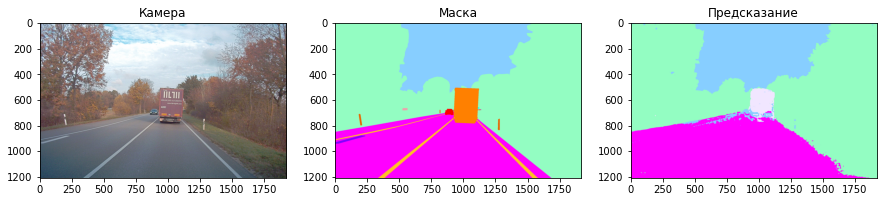

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
cam, lab = [plt.imread(i) for i in [camera_path, label_path]]
ax1.imshow(cam)
ax1.set_title('Камера')
ax2.imshow(lab)
ax2.set_title('Маска')
ax3.imshow(pred)
ax3.set_title('Предсказание')
plt.show()